# **Integrated Gradients for CNN Models**

Integrated Gradients(IG) are versatile in that they are model-agnostic and can be used as explainability tool for neural network models such as CNNs that use images as inputs. In this notebook, we shall apply IG for two pretrained DNN architectures - one for a pretrained Resnet and another for a x-ray classification image.


## **1. Load a pretrained CNN model**


- Let's use a pretrained Resnet50 model that was originally trained on ImageNet.

- We shall load the pretrained weights and apply the necessary image transformations (resize, crop, normalization)

torch.Size([64, 3, 7, 7])
Prediction: sports car with probability: 0.3885


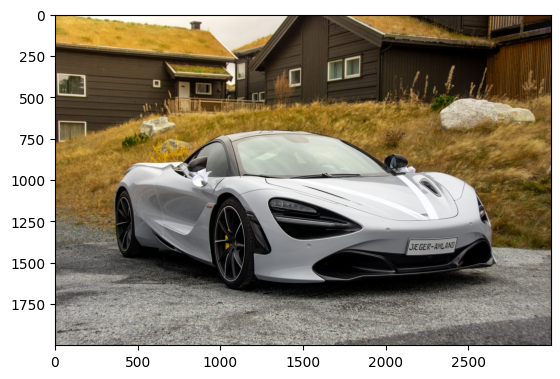

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
from torchvision import transforms
import urllib.request
from captum.attr import IntegratedGradients, NoiseTunnel
import matplotlib.pyplot as plt
from captum.attr import visualization as viz
import os

# First, we load pre-trained ResNet50
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights)

print(model.conv1.weight.shape)

preprocess = weights.transforms()

# Load test image
img = Image.open("test_images/img-1.jpg")
plt.imshow(img)
img_transformed = preprocess(img)
input_tensor = img_transformed.unsqueeze(0)


model.eval()

# Store unnormalized input for IG
raw_input_tensor = transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])(img).unsqueeze(0)



# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_batch = input_tensor.to(device)
raw_input_tensor = raw_input_tensor.to(device)
model.to(device)

# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get prediction
probabilities = torch.nn.functional.softmax(output[0], dim=0)
_, indices = torch.sort(output, descending=True)

# Check if the file already exists
if not os.path.exists("imagenet_classes.txt"):
    # Download ImageNet class labels
    url, filename = ("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", "imagenet_classes.txt")
    try:
        urllib.URLopener().retrieve(url, filename)
    except:
        urllib.request.urlretrieve(url, filename)

# Read the categories from the file
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Get the top predicted class index
predicted_class_idx = indices[0][0].item()

# Display the predicted class name and its probability
print(f"Prediction: {categories[predicted_class_idx]} with probability: {probabilities[predicted_class_idx].item():.4f}")


## **2. Compute the Integrated Gradients based feature attribution**

We compute integrated gradients for n=200 steps for model prediction on this image.

Computing integrated gradients...


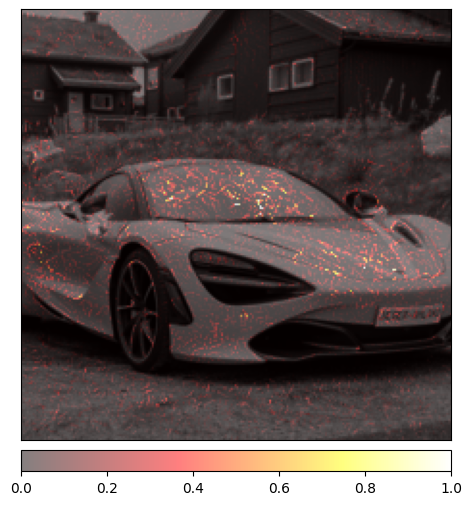

In [2]:

print("Computing integrated gradients...")
# Compute Integrated Gradients
# We will use 200 steps and 3 as the internal batch size. If you get OOM errors, you can reduce the internal batch size.
ig = IntegratedGradients(model)
attr, _ = ig.attribute(raw_input_tensor, target=indices[0][0], n_steps=200, internal_batch_size=3,return_convergence_delta=True)

# Visualization
default_cmap = plt.get_cmap('hot')
_ = viz.visualize_image_attr(np.transpose(attr.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img_transformed.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='blended_heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

# Free memory
del attr
torch.cuda.empty_cache()

- The figure above shows the IG attributions for the model predictions on the car image. However, notice that the attributions are rather noisy and are barely discernable.

- In order to obtain a smoother visualization of the attributions of the IG, here, we repeat the computation of IG across multiple noisy versions of the input image and subsequently smoothen across the samples (using mean-squared attributions). This method is implemented in Captum as the  `NoiseTunnel()` functionality.

- This helps reduce sensitivity to minor pixel changes and enhances generalization in feature attribution.

- The noise-smoothed IG results in a less noisy and more stable visualization.


## **3. Enhanced Visualization of Integrated Gradients**

- We can obtain a clearer IG attribution visualization using `NoiseTunnel()` approach. 
- We see that the model is focusing primarily on the shape and key elements of the car, rather than the background.
- Since IG + NoiseTunnel averages attributions over multiple noise-perturbed versions, it ensures that the explanation is more reliable than single-instance IG.
- This explains why certain car features (wheels, headlights, side windows) are dominant in the attributions.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


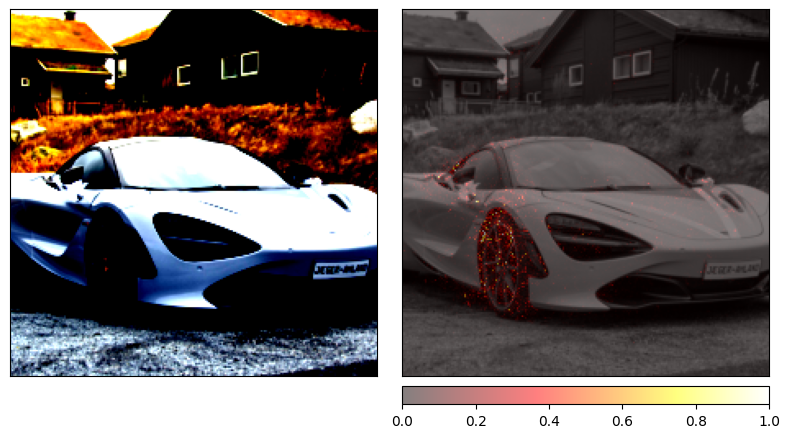

<Figure size 640x480 with 0 Axes>

In [3]:
ig = IntegratedGradients(model)

# Convert input tensor to grayscale
input_tensor_gray = transforms.Grayscale()(input_tensor)

# Convert grayscale tensor back to 3 channels
input_tensor_rgb = input_tensor_gray.repeat(1, 3, 1, 1).to(device)  # Ensure tensor is on the same device as the model

noise_tunnel = NoiseTunnel(ig)

# Use valid class index for target
valid_class_idx = output.argmax(dim=1).item()


# Reduce nt_samples and n_steps to avoid memory overload
attributions_ig_nt = noise_tunnel.attribute(input_tensor_rgb, nt_samples=5,nt_samples_batch_size=2, nt_type='smoothgrad_sq', target=valid_class_idx, n_steps=50)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(img_transformed.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

plt.suptitle('Integrated Gradients with Noise Tunnel')
plt.show()

## **4. Another example using a pretrained X-ray image classification model**

- In this next example, we use the `Torchvision` library and download a pre-trained model for x-ray classification. This demosntates the applicability in the medical domain

{'Atelectasis': 0.7733319, 'Consolidation': 0.76927257, 'Infiltration': 0.64465296, 'Pneumothorax': 0.5155935, 'Edema': 0.6992159, 'Emphysema': 0.5043472, 'Fibrosis': 0.5288869, 'Effusion': 0.9303298, 'Pneumonia': 0.63500106, 'Pleural_Thickening': 0.5475532, 'Cardiomegaly': 0.74253833, 'Nodule': 0.550002, 'Mass': 0.59922725, 'Hernia': 0.112260245, 'Lung Lesion': 0.70976853, 'Fracture': 0.5607468, 'Lung Opacity': 0.8480063, 'Enlarged Cardiomediastinum': 0.62694246}
Predicted Pathology: Effusion


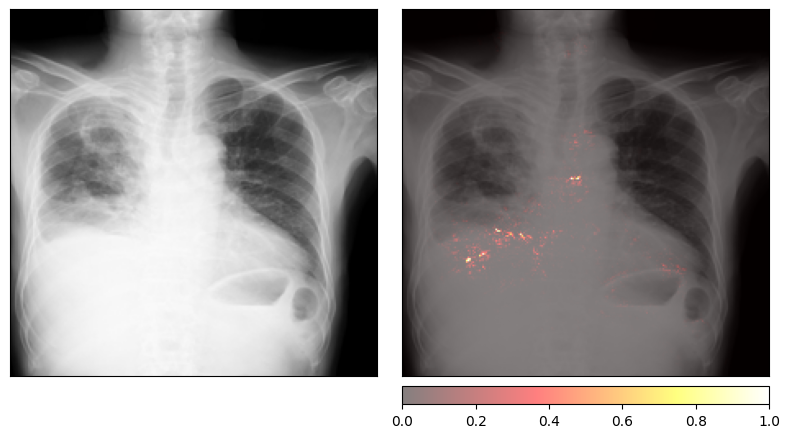

<Figure size 640x480 with 0 Axes>

In [4]:
import torchxrayvision as xrv
import torchvision

# Load and store original image before processing
original_img = Image.open("test_images/xray.jpg").convert('L')  # Convert to grayscale
original_img_resized = original_img.resize((224, 224))  # Resize for visualization
original_img_np = np.array(original_img_resized)  # Convert to NumPy array

# Normalize the image if needed
img = np.array(original_img_resized)
if img.max() > 1.0:
    img = xrv.datasets.normalize(img, 255)

# Ensure correct shape for model input
if img.ndim == 2:
    img = img[None, ...]  # Shape becomes (1, 224, 224)

# Apply X-Ray resizer transformation
transform = torchvision.transforms.Compose([xrv.datasets.XRayResizer(224)])
img_transformed = transform(img)
img_transformed = torch.from_numpy(img_transformed).float()

# Ensure correct channel format
if img_transformed.shape[0] == 3:  
    img_transformed = img_transformed[0].unsqueeze(0)  # Convert (3, 224, 224) → (1, 224, 224)

# Ensure batch dimension for the model
img_transformed = img_transformed.unsqueeze(0)  # Shape: (1, 1, 224, 224)

# Load model
model = xrv.models.DenseNet(weights="densenet121-res224-all")
model.eval()

# Predict
outputs = model(img_transformed)

# Display predictions
print(dict(zip(model.pathologies, outputs[0].detach().numpy())))
# Top 3 predicted pathologies
predicted_pathology = model.pathologies[outputs.argmax(dim=1).item()]
print(f'Predicted Pathology: {predicted_pathology}')

# Integrated Gradients & Noise Tunnel
ig = IntegratedGradients(model)
noise_tunnel = NoiseTunnel(ig)


default_cmap = plt.get_cmap('hot')

# Reduce `n_steps` and `nt_samples` to prevent crashes
attributions_ig_nt = noise_tunnel.attribute(
    img_transformed,
    nt_samples=5,  # Reduce this parameter to avoid OOM errors
    nt_type='smoothgrad_sq',
    nt_samples_batch_size=2,
    target=outputs.argmax(dim=1).item(),
    n_steps=50  # Reduced steps for faster computation
)

# Ensure attributions have the correct shape
attr = attributions_ig_nt.squeeze(0).cpu().detach().numpy()  # Remove batch dimension
attr = np.transpose(attr, (1, 2, 0))  # Ensure shape is (224, 224, 1)

# Convert original grayscale image to RGB for visualization
original_img_np = np.stack([original_img_np] * 3, axis=-1)  # Convert grayscale to RGB (224, 224, 3)

# Visualization with the original unprocessed image
_ = viz.visualize_image_attr_multiple(
    attr,
    original_img_np,  # Use the original image before any processing
    ["original_image", "blended_heat_map"],
    ["all", "positive"],
    cmap=default_cmap,
    show_colorbar=True
)

plt.suptitle(f'Integrated Gradients with Noise Tunnel for {predicted_pathology}')
plt.show()


### What is Pleural Effusion?

Pleural effusion is the abnormal accumulation of fluid within the pleural space, the thin cavity between the pleural layers surrounding the lungs. Pleural effusions can arise from various etiologies, ranging from heart failure and pneumonia to malignancies, such as lung cancer, and systemic inflammatory disorders, such as lupus.

**Observations**

- The highlighted regions (darkest areas) are in the lower lung fields.
- This aligns with common signs of pleural effusion, where fluid often accumulates in the lower lobes.
- The attributions are diffused, suggesting that the model relies on multiple areas rather than a single dominant feature.
- The spinal region and upper lung zones have minimal attributions, meaning the model is not relying on irrelevant regions.

![Pleural Effusion](Pleural%20Effusion.png)